In [1]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import random

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
# For reproducibility purposes
np.random.seed(42)

# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [4]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [5]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=256):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
        hop_length=hop_length, n_mels=128)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    #np.array([librosa.power_to_db(s, ref=np.max) for s in list(tsongs)])
    return np.array(list(tsongs))

In [6]:
def split_convert(X, y, debug=True):
    arr_specs, arr_genres = [], []
    
    # Convert to spectrograms and split into small windows
    for fn, genre in zip(X, y):
        signal, sr = librosa.load(fn)
        # Debug process
        if debug:
            print("Reading file: {}".format(fn))
        song_samples = sr*sample_time
        signal = signal[:song_samples]

        # Convert to dataset of spectograms/melspectograms
        signals, y = splitsongs(signal, genre)

        # Convert to "spec" representation
        specs = to_melspectrogram(signals)

        # Save files
        arr_genres.extend(y)
        arr_specs.extend(specs)
    
    outputA = np.array(arr_specs)
    outputB = to_categorical(arr_genres)
    return outputA, outputB

In [7]:
def read_data(src_dir, genres, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        for root, subdirs, files in os.walk(folder):
            for file in files:
                file_name = folder + "/" + file

                # Save the file name and the genre
                arr_fn.append(file_name)
                arr_genres.append(genres[x])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        arr_fn, arr_genres, test_size=0.3, random_state=42, stratify=arr_genres
    )
    
    # Split into small segments and convert to spectrogram
    X_train, y_train = split_convert(X_train, y_train, debug)
    X_test, y_test = split_convert(X_test, y_test, debug)

    return X_train, X_test, y_train, y_test

In [8]:
# Parameters
gtzan_dir = '../Data/songs/small_test_set/'
sample_time = 30 # seconds
genres = {'black': 0, 'death': 1}

# Read the data
X_train, X_test, y_train, y_test = read_data(gtzan_dir, genres, debug=True)

Reading file: ../Data/songs/small_test_set/death/(11)_[Death]_Land_Of_No_Return_(Mutilation_Demo).flac


C:\Users\user\anaconda3\envs\ml38b\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Reading file: ../Data/songs/small_test_set/death/07 - The Beasts Of The Apocalypse.mp3
Reading file: ../Data/songs/small_test_set/black/04 - The Source Of Icon E.flac
Reading file: ../Data/songs/small_test_set/death/(12)_[Death]_Land_Of_No_Return.flac
Reading file: ../Data/songs/small_test_set/black/08. Through The Halls Of Eternity.flac
Reading file: ../Data/songs/small_test_set/death/(09)_[Slaughter]_Tortured_Souls.flac
Reading file: ../Data/songs/small_test_set/black/03 - Night Of The Graveless Souls.mp3
Reading file: ../Data/songs/small_test_set/black/06. Eternal Years On The Path To Cemetary Gates.flac
Reading file: ../Data/songs/small_test_set/death/03 - March To Die.mp3
Reading file: ../Data/songs/small_test_set/death/(10)_[Death]_Legion_Of_Doom_(Back_From_The_Dead_Demo_1986).flac
Reading file: ../Data/songs/small_test_set/death/01. Dehydrated.mp3
Reading file: ../Data/songs/small_test_set/death/(08)_[Death]_Zombie_(Reign_Of_Terror_Demo).flac
Reading file: ../Data/songs/small_te

In [9]:
# outputA = np.array(X_train)
# print(outputA.shape)
# print(len(X_test))
# count = 0
# for sample in range(len(X_test)):
#     num_row = len(X_test[sample])
#     num_col = len(X_test[sample][0])
#     num_intensity = len(X_test[sample][0][0])
#     if (num_row != 128) or (num_col != 130) or (num_intensity != 1):
#         np.append(X_test[sample][127], X_test[sample][127])
#         np.append(X_test[sample][127], X_test[sample][127])
#         print(str(sample) + ' has been extended.')
#         #count += 1
# #print(count)

# #print(X_test[100][100][100])

# outputB = to_categorical(X_test)

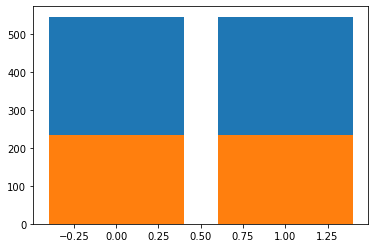

In [10]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# GTZAN Melspectrogram Generator

In [11]:
from tensorflow.keras.utils import Sequence

class GTZANGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, is_test = False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test
    
    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]

        # Apply data augmentation
        if not self.is_test:
            signals = self.__augment(signals)
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]
    
    def __augment(self, signals, hor_flip = 0.5, random_cutout = 0.5):
        spectrograms =  []
        for s in signals:
            signal = copy(s)
            
            # Perform horizontal flip
            if np.random.rand() < hor_flip:
                signal = np.flip(signal, 1)

            # Perform random cutoout of some frequency/time
            if np.random.rand() < random_cutout:
                lines = np.random.randint(signal.shape[0], size=3)
                cols = np.random.randint(signal.shape[0], size=4)
                signal[lines, :, :] = -80 # dB
                signal[:, cols, :] = -80 # dB

            spectrograms.append(signal)
        return np.array(spectrograms)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None

# Custom CNN (Melspectrogram version)

In [12]:
def conv_block(x, n_filters, pool_size=(2, 2)):
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.25)(x)
    return x

In [13]:
# Model Definition
def create_model(input_shape, num_genres):
    inpt = Input(shape=input_shape)
    x = conv_block(inpt, 16)
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)
    
    # Global Pooling and MLP
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions)
    return model

In [33]:
model = create_model(X_train[0].shape, 2)
#model = create_model((128, 130, 1), 2)
#print(X_train.shape)

In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 130, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 130, 16)      160       
                                                                 
 activation_5 (Activation)   (None, 128, 130, 16)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 65, 16)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 64, 65, 16)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 65, 32)        4640      
                                                           

### Loss function

In [35]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [36]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)

In [43]:
# Generators
batch_size = 32
train_generator = GTZANGenerator(X_train, y_train.astype(int))
steps_per_epoch = np.ceil(len(X_train)/batch_size)

validation_generator = GTZANGenerator(X_test, y_test.astype(int))
val_steps = np.ceil(len(X_test)/batch_size)

In [44]:

hist = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=100,
    verbose=1,
    callbacks=[reduceLROnPlat])

Epoch 1/100
18/18 [==============================] - 1s 34ms/step - loss: 9.0566 - accuracy: 0.6077 - val_loss: 8.6723 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 1s 31ms/step - loss: 8.4099 - accuracy: 0.5931 - val_loss: 8.0098 - val_accuracy: 0.5898 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 1s 29ms/step - loss: 7.7055 - accuracy: 0.6423 - val_loss: 7.3987 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 1s 31ms/step - loss: 7.0704 - accuracy: 0.7326 - val_loss: 7.1544 - val_accuracy: 0.4766 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 1s 29ms/step - loss: 6.6600 - accuracy: 0.6460 - val_loss: 6.4062 - val_accuracy: 0.5781 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 1s 30ms/step - loss: 6.2217 - accuracy: 0.6441 - val_loss: 5.9919 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 7/100
18/18 [==============================] - 1s 27ms/step - lo

In [45]:
#X_test1 = hash(tuple(X_test))
#y_test1 = hash(tuple(y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 1.088 and val_acc = 0.650


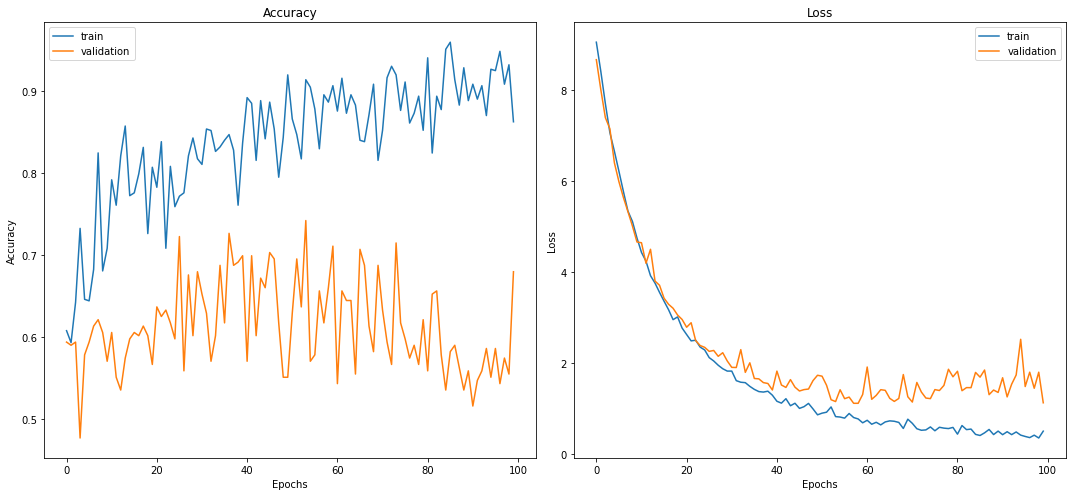

In [46]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


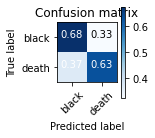

In [49]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(2, 2))
plot_confusion_matrix(cm, keys, normalize=True)

## Majority Vote

In [25]:
def majority_vote(scores):
    values, counts = np.unique(scores,return_counts=True)
    ind = np.argmax(counts)
    return values[ind]

In [26]:
preds = model.predict(X_test, batch_size=32, verbose=0)

In [29]:
# Each sound was divided into 39 segments in our custom function
scores_songs = np.split(np.argmax(preds, axis=1), 2)
scores_songs = [majority_vote(scores) for scores in scores_songs]

In [31]:
# Same analysis for split
label = np.split(np.argmax(y_test, axis=1), 2)
label = [majority_vote(l) for l in label]

In [32]:
from sklearn.metrics import accuracy_score

print("majority voting system (acc) = {:.3f}".format(accuracy_score(label, scores_songs)))

majority voting system (acc) = 1.000


Compared to the classical approach, we are winning now!

We passed from a 78.8% accuracy to **82%**. It is not a great improvement but this is a really simple architecture.

## Save the model

In [ ]:
# Save the model
model.save('../models/custom_cnn_2d.h5')